In [80]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn import ensemble
import pandas as pd
import numpy as np
import datetime
#coding:utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

dtfmt = '%Y-%m-%d %H:%M:%S' 
import timeit
import time
import itertools
import datetime
import lightgbm as lgbm
import math
from  sklearn.metrics import mean_squared_error
import fea_utils as futils

In [245]:
def gen_fea(user_fn, click_fn, order_fn, loan_fn , loan_sum_fn):
    # step 0. INIT raw data
    user_df = pd.read_csv(user_fn)
    loan_df = pd.read_csv(loan_fn)
    loan_sum_fn = pd.read_csv(loan_sum_fn)

    user_df['real_limit'] = user_df.limit.map(lambda la : futils.to_real_loan(la))
    
    #step 1 . convert load data to real data space     
    loan_df = transform(loan_df , 'loan_amount')
    loan_sum_df = transform(loan_sum_fn , 'loan_sum')
    
    #step 2 . add loan month , dt 
    loan_df['month'] = loan_df.loan_time.apply(lambda x : x[5:7]).astype('int')
    
    #step 3. user per month
    poi_set = list(set(user_df.uid))
    months = [8 , 9 ,10 , 11]
    poi_month = []
    import itertools
    for x in itertools.product(poi_set , months):
        poi_month.append(x)
    poi_per_month_df = pd.DataFrame(poi_month , columns=['uid','month'])
    
    #step 4. user loan agg info, mean,max,median,

    func_names = ['sum','mean','std', 'min' ,'max' ,'median','mad','skew','kurt' ]
    funcs = [np.sum , np.mean , np.std , np.min , np.max , np.median ,pd.Series.mad , pd.Series.skew , pd.Series.kurt]
    column_names = [ 'real_loan_amount_' + t for t in func_names]
    user_statistics_df = loan_df.groupby(['uid']).agg({"real_loan_amount":funcs , 'plannum':funcs})
    user_statistics_amount_df = user_statistics_df['real_loan_amount'] 
    user_statistics_amount_df.columns = column_names
    user_statistics_amount_df = user_statistics_amount_df.reset_index() # add uid to column
    user_agg_df = user_statistics_amount_df
    
#     user_statistics_plannum_df = user_statistics_df['plannum']
#     column_names = [ 'plannum' + t for t in func_names]
#     user_statistics_plannum_df.columns = column_names
#     user_statistics_plannum_df = user_statistics_plannum_df.reset_index() #add uid to column 
    
#    user_agg_df = pd.merge(user_statistics_amount_df ,user_statistics_plannum_df , on=['uid'])
    
        
    #step 5. user month loan sum 
       
    user_month_sum_df = loan_df.groupby(['uid','month']).agg({"real_loan_amount": np.sum ,"plannum":np.sum }).reset_index()
    
    #setp 6. user month loan sum agg info. mean,max,....
    column_names = [ 'real_loan_amount_month_' + t for t in func_names]
    user_month_statistics_df = user_month_sum_df.groupby(['uid']).agg({"real_loan_amount":funcs , 'plannum':funcs})
    user_month_statistics_amount_df = user_month_statistics_df[['real_loan_amount']]
    user_month_statistics_amount_df.columns = column_names
    user_month_statistics_amount_df = user_month_statistics_amount_df.reset_index()
    user_month_agg_df = user_month_statistics_amount_df
    
#     column_names = [ 'plannum_month_' + t for t in func_names]
#     user_month_statistics_plannum_df = user_month_statistics_df[['plannum']]
#     user_month_statistics_plannum_df.columns = column_names
#     user_month_statistics_plannum_df = user_month_statistics_plannum_df.reset_index()
        
#     user_month_agg_df = pd.merge(user_month_statistics_amount_df ,user_month_statistics_plannum_df , on=['uid'] )
    
    
    
    #step 7. user month loan sum 
    
    flatten_user_month_sum_df = pd.merge( poi_per_month_df , user_month_sum_df , on=['uid' , 'month'] , how='left').fillna(0)
    flatten_user_month_sum_df = flatten_user_month_sum_df.fillna(0)
    
    flatten_user_month_sum_df = flatten_user_month_sum_df.set_index(['uid','month'])['real_loan_amount'].unstack().reset_index()
    flatten_user_month_sum_df.columns = [ 'uid','aug','sep','oct','nov']
    
    
    #step 8. feature agg 
    
    user_loan_feature_df = pd.merge(flatten_user_month_sum_df , user_agg_df , on=['uid'] , how='left' ).fillna(0)
    user_loan_feature_df = pd.merge(user_loan_feature_df , user_month_agg_df , on=['uid'] , how='left').fillna(0)
    user_loan_feature_df = pd.merge(user_loan_feature_df , loan_sum_df , on=['uid'] , how='left').fillna(0)
    user_loan_feature_df = pd.merge(user_loan_feature_df , user_df[['uid','real_limit','age','sex']] , on=['uid'])
    #step 9. save file 
    user_loan_feature_df.to_csv("user_all.csv")
    return user_loan_feature_df[['uid','aug','sep','oct','nov','real_loan_amount_sum','real_loan_amount_mean','real_loan_amount_std','real_loan_amount_min','real_loan_amount_max','real_loan_amount_median','real_loan_amount_mad','real_loan_amount_skew','real_loan_amount_kurt','real_loan_amount_month_sum','real_loan_amount_month_mean','real_loan_amount_month_std','real_loan_amount_month_min','real_loan_amount_month_max','real_loan_amount_month_median','real_loan_amount_month_mad','real_loan_amount_month_skew','real_loan_amount_month_kurt','loan_sum','real_loan_sum','real_limit','age','sex']]

def transform(data , column_name):
   
    new_column_name = "real_" + column_name
    new_column = data[column_name].apply(lambda x :5**x - 1)
    data[new_column_name] = new_column
    return data 

In [246]:

st = datetime.datetime.now()
user_fn = '../../../raw_data/t_user.csv'
click_fn = '../../../raw_data/t_click.csv'
order_fn = '../../../raw_data/t_order.csv'
loan_fn = '../../../raw_data/t_loan.csv'
loan_sum_fn = '../../../raw_data/t_loan_sum.csv'

train_data = gen_fea(user_fn, click_fn, order_fn, loan_fn , loan_sum_fn)
et = datetime.datetime.now()
print 'time cost : ' + str(et - st)

time cost : 0:01:50.224512


# 构造训练集

In [153]:
user_month_date = pd.read_csv('fea_user_month.csv')
dataset = pd.merge(train_data , user_month_date , on = ['uid'] , how='left')

In [175]:
dataset.columns

Index([u'uid', u'aug', u'sep', u'oct', u'nov', u'real_loan_amount_sum',
       u'real_loan_amount_mean', u'real_loan_amount_std',
       u'real_loan_amount_min', u'real_loan_amount_max',
       u'real_loan_amount_median', u'real_loan_amount_mad',
       u'real_loan_amount_skew', u'real_loan_amount_kurt',
       u'real_loan_amount_month_sum', u'real_loan_amount_month_mean',
       u'real_loan_amount_month_std', u'real_loan_amount_month_min',
       u'real_loan_amount_month_max', u'real_loan_amount_month_median',
       u'real_loan_amount_month_mad', u'real_loan_amount_month_skew',
       u'real_loan_amount_month_kurt', u'loan_sum', u'real_loan_sum',
       u'real_limit_x', u'age', u'sex', u'Unnamed: 0', u'month',
       u'real_limit_y', u'month_need_pay', u'left_balance',
       u'real_loan_amount', u'tuned_limit'],
      dtype='object')

In [176]:
train = dataset[dataset.month==10]
test = dataset[dataset.month==11]

drop_list = ['uid' , 'nov' , 'real_loan_sum' , 'month','loan_sum','Unnamed: 0','age','sex','real_limit_x','real_limit_y']
train_feature_names = np.setdiff1d(train.columns , drop_list)
target = ['loan_sum']

drop_list = ['uid' , 'aug' , 'real_loan_sum' , 'month','loan_sum','Unnamed: 0','age','sex','real_limit_x','real_limit_y']
test_feature_names = np.setdiff1d(test.columns , drop_list)


In [183]:
len(train_feature_names)

25

In [234]:
y_train = (train[target].values)[: , 0]
y_test = (train[target].values)[:,0]
X_train = train[train_feature_names].values
X_test = train[train_feature_names].values

X_predict= test[test_feature_names].values
# create dataset for lightgbm
lgb_train = lgbm.Dataset(X_train, y_train)
lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)


params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective':'regression',
    'max_depth':5, 
    'metric':{'l2','auc'},
    'num_trees': 150,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    
}

gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval
               )


[1]	valid_0's l2: 5.2559	valid_0's auc: 0.979374
[2]	valid_0's l2: 5.17925	valid_0's auc: 0.987679
[3]	valid_0's l2: 5.10467	valid_0's auc: 0.988735
[4]	valid_0's l2: 5.03095	valid_0's auc: 0.987495
[5]	valid_0's l2: 4.9587	valid_0's auc: 0.987142
[6]	valid_0's l2: 4.88823	valid_0's auc: 0.986761
[7]	valid_0's l2: 4.81885	valid_0's auc: 0.986893
[8]	valid_0's l2: 4.7512	valid_0's auc: 0.98596
[9]	valid_0's l2: 4.68446	valid_0's auc: 0.985878
[10]	valid_0's l2: 4.61954	valid_0's auc: 0.986133
[11]	valid_0's l2: 4.55545	valid_0's auc: 0.986793
[12]	valid_0's l2: 4.49255	valid_0's auc: 0.986475
[13]	valid_0's l2: 4.43094	valid_0's auc: 0.9873
[14]	valid_0's l2: 4.37047	valid_0's auc: 0.987193
[15]	valid_0's l2: 4.31195	valid_0's auc: 0.988468
[16]	valid_0's l2: 4.25355	valid_0's auc: 0.988326
[17]	valid_0's l2: 4.19764	valid_0's auc: 0.988724
[18]	valid_0's l2: 4.14196	valid_0's auc: 0.988767
[19]	valid_0's l2: 4.08677	valid_0's auc: 0.988975
[20]	valid_0's l2: 4.0333	valid_0's auc: 0.989

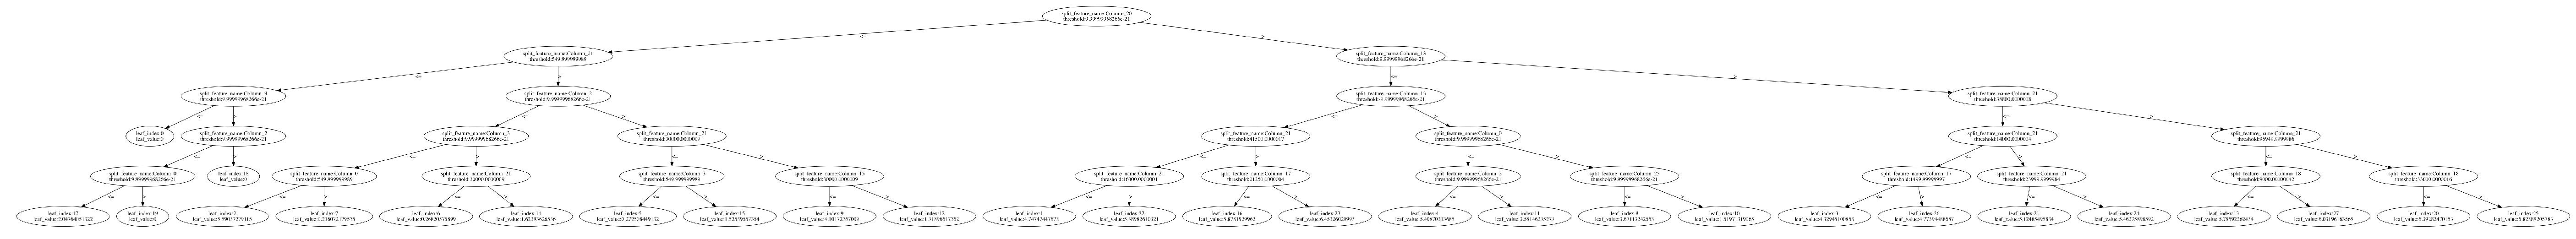

In [173]:
lgbm.plot_tree(gbm , figsize=(100,100))

In [222]:
 pd.DataFrame(zip(train_feature_names, gbm.feature_importance(importance_type='split', iteration=-1))  , columns=['featuren','importance']).sort_values(['importance'] , ascending=False)

,featuren,importance
19,real_loan_amount_month_sum,499
14,real_loan_amount_month_mean,363
0,aug,267
15,real_loan_amount_month_median,193
2,month_need_pay,190
11,real_loan_amount_month_kurt,178
23,sep,168
16,real_loan_amount_month_min,142
3,oct,139
13,real_loan_amount_month_max,94


In [235]:
#train rmse
res = pd.DataFrame( zip(gbm.predict(X_train) , y_train) , columns=['predict','gt']  )
res['uid'] = train_data.uid
mean_squared_error(res['gt'] , res.predict)

1.2697032056417861

(array([ 61880.,   2493.,   2203.,   3866.,   3262.,   3714.,   3365.,
          4728.,   3831.,   1651.]),
 array([ 0.15081186,  0.68066362,  1.21051538,  1.74036714,  2.2702189 ,
         2.80007065,  3.32992241,  3.85977417,  4.38962593,  4.91947769,
         5.44932944]),
 <a list of 10 Patch objects>)

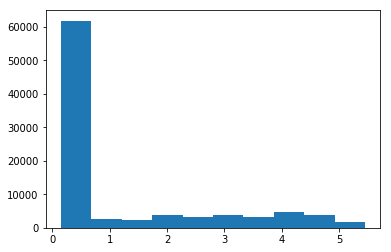

In [236]:
plt.hist(res.predict)

In [237]:
res.columns

Index([u'predict', u'gt', u'uid'], dtype='object')

(array([  7.14730000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   7.81000000e+02,   3.58500000e+03,
          8.53500000e+03,   6.09300000e+03,   5.19000000e+02,
          7.00000000e+00]),
 array([ 0.        ,  0.84330191,  1.68660382,  2.52990573,  3.37320764,
         4.21650955,  5.05981146,  5.90311337,  6.74641527,  7.58971718,
         8.43301909]),
 <a list of 10 Patch objects>)

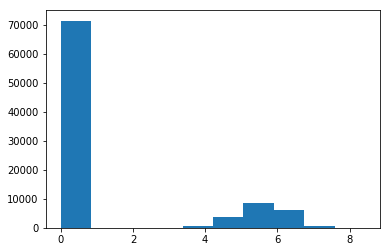

In [238]:
plt.hist(res['gt'])

In [243]:
#submmision
res = pd.DataFrame( (gbm.predict(X_predict) ) , columns=['predict_real']  )
res['uid'] = train_data.uid
res[['uid','predict_real']].to_csv('../model/20171202.csv',index=False, header=False,)

In [244]:
res.shape[0]

90993

In [173]:
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
res.shape[0]

90993

In [193]:
plt.hist(res.predict_real)

46

(array([ 54296.,      0.,      0.,    687.,     75.,  16415.,      0.,
             0.,      0.,  19520.]),
 array([ 0.        ,  0.28675356,  0.57350712,  0.86026068,  1.14701424,
         1.4337678 ,  1.72052136,  2.00727492,  2.29402848,  2.58078204,
         2.8675356 ]),
 <a list of 10 Patch objects>)

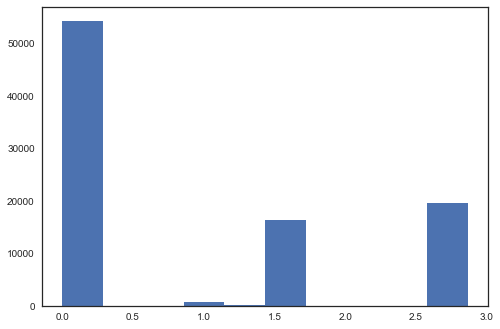

In [235]:
plt.hist(res.predict_trans)

In [204]:
def cal_corre(train):
    sns.set(style="white")


    # Compute the correlation matrix
    corr = train.corr()


    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()


(array([  8.94080000e+04,   1.32100000e+03,   1.83000000e+02,
          5.20000000e+01,   1.80000000e+01,   4.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([      0.        ,   32999.99999898,   65999.99999796,
          98999.99999694,  131999.99999593,  164999.99999491,
         197999.99999389,  230999.99999287,  263999.99999185,
         296999.99999083,  329999.99998982]),
 <a list of 10 Patch objects>)

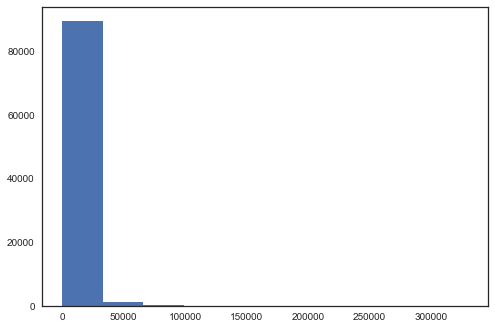

In [244]:
plt.hist(train_data.aug)

In [44]:
res = pd.read_table('../model/20171201.csv',sep=',')

In [45]:
res.columns

Index([u'1', u'0.0'], dtype='object')

,1,0.0
0,2,0.000000
1,3,0.000000
2,4,3.478264
3,5,1.933687
4,6,3.685598
5,7,0.000000
6,8,0.000000
7,9,0.000000
8,10,0.000000
9,11,0.000000


In [228]:
p1 = pd.read_csv('../model/20171201.csv')

In [241]:
p2 = pd.read_csv('../model/20171202.csv')

(array([ 60227.,   1618.,    962.,   5882.,   7555.,   3254.,   2720.,
          4389.,   2973.,   1412.]),
 array([ 0.        ,  0.62240939,  1.24481878,  1.86722817,  2.48963756,
         3.11204695,  3.73445633,  4.35686572,  4.97927511,  5.6016845 ,
         6.22409389]),
 <a list of 10 Patch objects>)

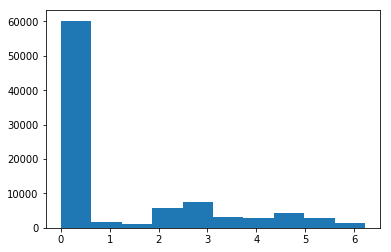

In [231]:
plt.hist(p1.iloc[:,1])

(array([ 57332.,   4481.,   5562.,   5918.,   5026.,   2755.,   2578.,
          3249.,   2888.,   1203.]),
 array([ 0.12653045,  0.67502049,  1.22351053,  1.77200057,  2.3204906 ,
         2.86898064,  3.41747068,  3.96596071,  4.51445075,  5.06294079,
         5.61143083]),
 <a list of 10 Patch objects>)

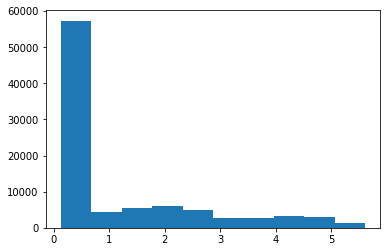

In [242]:
plt.hist(p2.iloc[:,1])

(array([ 61821.,   2524.,   4195.,   2856.,   2507.,   7127.,   1587.,
          4186.,   2773.,   1416.]),
 array([ 0.        ,  0.67294547,  1.34589093,  2.0188364 ,  2.69178187,
         3.36472734,  4.0376728 ,  4.71061827,  5.38356374,  6.05650921,
         6.72945467]),
 <a list of 10 Patch objects>)

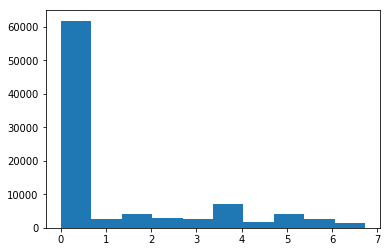

In [232]:
plt.hist(p2.iloc[:,1])

(array([ 61692.,   2654.,   4817.,   2269.,   2019.,   7613.,   1533.,
          4241.,   2739.,   1416.]),
 array([ 0.        ,  0.67555495,  1.35110989,  2.02666484,  2.70221979,
         3.37777474,  4.05332968,  4.72888463,  5.40443958,  6.07999453,
         6.75554947]),
 <a list of 10 Patch objects>)

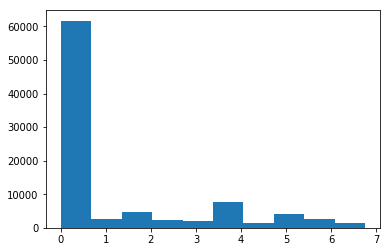

In [212]:
plt.hist(res.predict_real)

In [214]:
res.columns

Index([u'predict_real', u'uid'], dtype='object')

In [247]:
def gen_user_date(user_df , loan_df):
	date_all = loan_df['loan_time'].str.split(' ', expand=True)[0]
	start_date = pd.to_datetime(date_all.min(), format='%Y-%m-%d')
	end_date = pd.to_datetime(date_all.max(), format='%Y-%m-%d')
	date_list = map(lambda d : datetime.datetime.strftime(d, '%Y-%m-%d'), pd.date_range(start_date, end_date).tolist())
	date_df = pd.DataFrame(data={'date' : date_list})
	# step 2. join user_df and date_df ('uid', 'active_date', 'date')
	user_df['key'] = 1
	date_df['key'] = 1
	user_date_df = pd.merge(user_df, date_df, on='key')
	user_date_df['month'] = user_date_df.date.apply(lambda x : str(x)[5 :7 ]).astype('int')
	del user_date_df['key']
	return user_date_df[['uid','date','month']]


In [248]:
user_df = pd.read_csv(user_fn)
loan_df = pd.read_csv(loan_fn)

In [249]:
res = gen_user_date(user_df , loan_df)

In [251]:
len(user_df),len(res)

(90993, 10919160)

In [255]:
len(res.groupby(['uid']).size())

90993

In [256]:
agg = res.groupby(['uid']).agg({"month":pd.Series})
agg[agg.month != 4]

,month
uid,
1,120
2,120
3,120
4,120
5,120
6,120
7,120
8,120
9,120


In [258]:
len(set(res.date))

120

In [261]:
user_month_date = pd.read_csv('fea_user_month_date.csv')

In [260]:
user_month_date.columns

Index([u'uid,date,month,real_limit,month_need_pay,left_balance,real_loan_amount,tuned_limit'], dtype='object')

In [262]:
user_month_date[['uid','month','month_need_pay']].drop_duplicates().shape[0]

363972

In [264]:
list(train_feature_names)

['aug',
 'left_balance',
 'month_need_pay',
 'oct',
 'real_loan_amount',
 'real_loan_amount_kurt',
 'real_loan_amount_mad',
 'real_loan_amount_max',
 'real_loan_amount_mean',
 'real_loan_amount_median',
 'real_loan_amount_min',
 'real_loan_amount_month_kurt',
 'real_loan_amount_month_mad',
 'real_loan_amount_month_max',
 'real_loan_amount_month_mean',
 'real_loan_amount_month_median',
 'real_loan_amount_month_min',
 'real_loan_amount_month_skew',
 'real_loan_amount_month_std',
 'real_loan_amount_month_sum',
 'real_loan_amount_skew',
 'real_loan_amount_std',
 'real_loan_amount_sum',
 'sep',
 'tuned_limit']

In [265]:
user_df.columns

Index([u'uid', u'age', u'sex', u'active_date', u'limit', u'key'], dtype='object')

In [266]:
user_df['limit_bucket'] = user_df.limit.astype('int')

In [267]:
import seaborn as sns

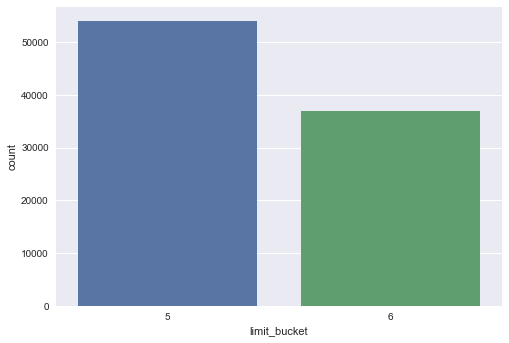

In [268]:
sns.countplot(user_df.limit_bucket)

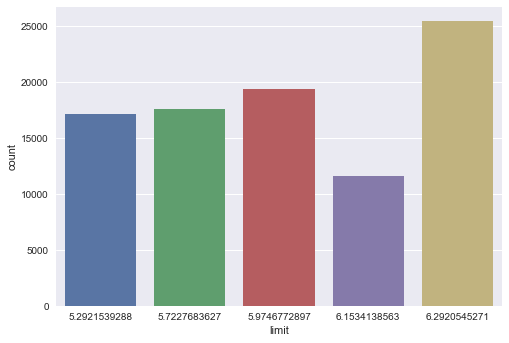

In [274]:
sns.countplot(user_df.limit)

In [270]:
5**5-1

3124

In [271]:
6**5-1

7775

In [272]:
7**5-1

16806

In [275]:
set(user_df.limit)

{5.2921539288000004,
 5.7227683627000001,
 5.9746772897000007,
 6.1534138563000003,
 6.2920545271000003}

In [276]:
dummies = pd.get_dummies(user_df.limit)

In [278]:
from sklearn import preprocessing

In [279]:
le = preprocessing.LabelEncoder()

In [281]:
le.fit(list(set(user_df.limit)))

LabelEncoder()

In [282]:
le.transform(list(set(user_df.limit)))

array([0, 3, 4, 2, 1])

In [283]:
list(set(user_df.limit))

[5.2921539288000004,
 6.1534138563000003,
 6.2920545271000003,
 5.9746772897000007,
 5.7227683627000001]

In [284]:
user_df['limit_cat'] = le.transform(user_df.limit)

In [287]:
pd.DataFrame( data={'limit_cat' :list(set(user_df.limit)) })


,limit_cat
0,5.292154
1,6.153414
2,6.292055
3,5.974677
4,5.722768


In [289]:
limit_date_df  = pd.read_csv('limit_date_dim.csv')

In [291]:
limit_date_df.head(100)

,uid,date,limit_cat,clk_cnt_1d,clk_cnt_3d,clk_cnt_7d,clk_cnt_14d,clk_cnt_21d,clk_cnt_30d,clk_cnt_60d,...,ctr_90d,loan_1d,loan_1d.1,loan_3d,loan_7d,loan_14d,loan_21d,loan_30d,loan_60d,loan_90d
0,26308,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
1,17067,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
2,46744,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
3,48366,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
4,87746,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
5,3113,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
6,90012,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
7,45006,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
8,73677,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
9,88516,2016-10-31,2,12653,38046.0,105011.0,222655.0,355252.0,519561.0,1096827.0,...,0.524273,13.3752,13.3752,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
